# Pitch Type PCA
### Perform PCA on Trackman Data

## Background
#### Trackman
Trackman ia a radar-based system installed in all Major League Baseball stadiums that records various measures on every pitch thrown. The system records the location of the pitch 100 times per second, and uses those locations to calculate measures on each pitch such as velocity,  break (horizontal and vertical movement off the pitch's initial trajectory) spin rate, spin direction and many others.

#### Pitch Types
Every pitcher throws a distinct number of pitch types, and these pitch types are manually classified in the data released by MLB. However information about pitch types can be gleaned from the measures in the Trackman data. For example how fastballs have a higher velocity than curveballs, or how sliders and curveballs move to the pitcher's non-throwing-arm side, while fastballs and changeups move to the pitcher's throwing-arm side.

#### Principal Components
Much of the data in Trackman is highly correlated and have clear relationships. These relationships are not necessarily linear, but for instance, horizontal break (break x) is going to be driven by horizontal acceleration at 50 feet (ax50). Reducing the data set down to its principal component (or components) is therefore helpful in preparing our feature set for analysis. 

## Data Prep and Exploration

Import the data into a DataFrame

In [1]:
import pandas as pd
tm_all = pd.read_csv("./2018_trackman_sample.csv").dropna(axis = 0) # remove rows with missing values
tm_all.head()

,pitcher,p_hand,pitch_type,pitch_name,velocity,spin_rate,horz_break,vert_break,release_x,release_z,extension,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,453286,R,SL,Slider,85.3,2213.0,0.1879,0.0932,-3.6817,4.8871,5.904,-0.0943,1.4981,8.0021,-124.0765,-1.9076,0.5072,22.0096,-31.0910
1,453286,R,FF,4-Seam Fastball,93.1,2568.0,-0.7428,1.1709,-3.7813,4.8487,6.480,-0.0185,2.2353,11.3063,-135.1627,-3.5155,-11.5300,28.1884,-17.1813
2,453286,R,FF,4-Seam Fastball,93.4,2421.0,-0.7818,1.1671,-3.6469,4.7835,6.503,1.1850,2.4390,14.1621,-135.3068,-2.8429,-12.6030,27.7924,-17.3131
3,453286,R,SL,Slider,84.0,2267.0,-0.0212,0.2403,-3.7483,4.9935,6.137,0.0360,2.6276,8.7656,-122.0618,0.3976,-1.7594,21.5489,-30.0450
4,453286,R,FF,4-Seam Fastball,92.8,2496.0,-0.8684,1.0067,-3.7169,4.6742,5.946,0.1655,2.7516,11.6873,-134.6450,-1.2983,-12.8010,26.7680,-19.9855


In [2]:
len(tm_all.index)

23132

So we have 15 features and over 23,000 rows. Some element of dimensionality reduction could clearly help make this a simpler learning task if the ultimate goal is classification. Let's look into PCA to do this then. 

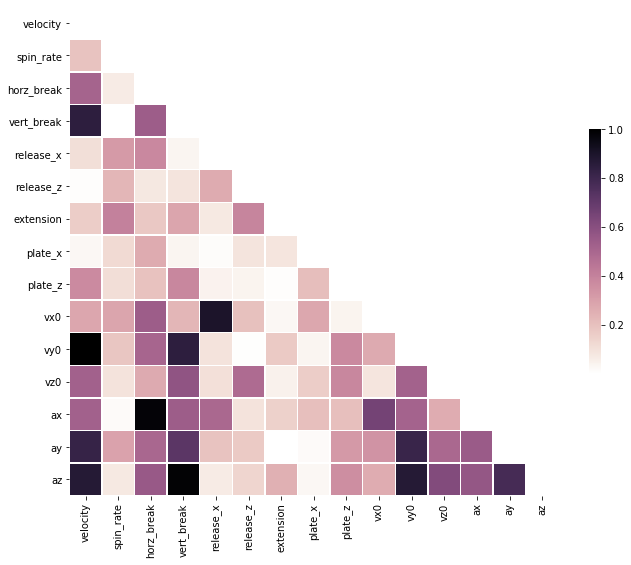

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# remove pitch type as it is a categorical column
tm = tm_all.loc[:,'velocity':'az']

# get the absolute value correlation matrix for all 15 features in tm
corr = abs(tm.corr())

# set the entire upper half of the matrix equal to 0
mask = np.triu(corr,0)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask = mask, vmax=1, center=.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Principal Component Analysis

There is clear correlation between many of the measures, including strong correlation between a few of the measures

In [4]:
from sklearn.decomposition import PCA
pca = PCA(.9).fit(tm)
pd.DataFrame(pca.components_, columns = tm.columns)

,velocity,spin_rate,horz_break,vert_break,release_x,release_z,extension,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,-0.003353,-0.999963,-0.000165,0.000003,0.001655,-0.000375,0.000473,-0.000302,-0.000284,-0.004558,0.00463,0.000794,0.000509,-0.00361,-0.001963


The scale of the data is clearly throwing off the PCA (as spin rate is overpowering everything else). So we will scale the data and perform the analysis again

Based on the Velo vs Spin plot, it looks like K-means is overvaluing spin rate and undervaluing velocity. This is most likely due to the higher variance for Spin Rate compared to Velocity. To account for this, we'll repeat the clustering with normalized data.

In [5]:
from sklearn.preprocessing import scale
tm_scaled = scale(tm)
pca_scaled = PCA(.9).fit(tm_scaled)
pd.DataFrame(pca_scaled.components_, columns = tm.columns)

,velocity,spin_rate,horz_break,vert_break,release_x,release_z,extension,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,-0.371800,-0.071857,0.301564,-0.364966,0.124478,-0.024253,-0.075763,0.026906,-0.145061,-0.201724,0.369884,0.224625,0.312627,-0.348702,-0.376270
1,0.130452,-0.077054,0.238053,0.176542,0.545701,0.343687,0.012337,0.033704,-0.012317,-0.485642,-0.135523,-0.310993,0.289808,0.083946,0.172890
2,-0.010324,0.516663,0.150114,-0.105335,-0.184494,0.390066,-0.504004,0.339142,-0.137663,0.223275,0.021565,-0.218694,0.086311,0.130092,-0.051264
3,-0.073657,-0.276469,-0.084313,0.013704,-0.023434,-0.063768,0.291535,0.339539,-0.672856,0.168240,0.077565,-0.448389,-0.081245,-0.105046,0.014271
4,-0.181318,-0.122267,-0.388583,-0.093458,0.028333,0.416505,-0.262892,-0.569512,-0.160043,-0.120471,0.185801,-0.195930,-0.324932,-0.033523,-0.070470
5,-0.165599,-0.459393,-0.176428,0.095322,0.121956,0.367154,-0.102850,0.527326,0.409701,0.158517,0.168879,0.148304,-0.166262,-0.094664,0.053804


In [6]:
# check the explained variance of the components
pca_scaled.explained_variance_

array([6.07320237, 2.39765393, 1.97506083, 1.47419563, 1.12904919,
       0.71299801])

With our princinpal components figured out, its time to apply the principal components to logistic regression. 

In [7]:
from sklearn.linear_model import LogisticRegression
pca_train = pca_scaled.transform(tm_scaled)
is_fb = np.isin(tm_all.pitch_type,['FF','SI'])

fb_logit = LogisticRegression()
fb_logit.fit(pca_train,is_fb)
print("Logit regression using PCA returns a {:.2%} accuracy rate.".format(fb_logit.score(pca_train,is_fb)))

Logit regression using PCA returns a 95.92% accuracy rate.
